# Taxi Cab Trips Exploratory Data Analysis

#### The goal of this project is to ultimately predict the cost of a ride before it is taken, if you imagine using the UBER app, and you can see how much a ride will cost you before you take it, that number is derrived from a lot of variables such as time of day, location of pickup/dropoff (these areas may have more traffic), distance of the trip itself, and many more. Much of the exploration herein will be in lieu of this fact, and other intervariable relationships will not be looked at. It should also be noted that in the interest of showing more skills some calculations are done that are not strictly necessary or at the very least not perfectly efficient.

### Imports and load dataset

In [33]:
import pandas as pd, seaborn as sns, numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from datetime import datetime, date, timedelta

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.linear_model import LinearRegression

df = pd.read_csv("2017_Yellow_Taxi_Trip_Data.csv")

### Get a sense of the data and if the fields are logically sound

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             22699 non-null  int64  
 1   VendorID               22699 non-null  int64  
 2   tpep_pickup_datetime   22699 non-null  object 
 3   tpep_dropoff_datetime  22699 non-null  object 
 4   passenger_count        22699 non-null  int64  
 5   trip_distance          22699 non-null  float64
 6   RatecodeID             22699 non-null  int64  
 7   store_and_fwd_flag     22699 non-null  object 
 8   PULocationID           22699 non-null  int64  
 9   DOLocationID           22699 non-null  int64  
 10  payment_type           22699 non-null  int64  
 11  fare_amount            22699 non-null  float64
 12  extra                  22699 non-null  float64
 13  mta_tax                22699 non-null  float64
 14  tip_amount             22699 non-null  float64
 15  to

## Column Cleanup and Addition

We have two values "tpep_pickup_datetime" and "tpep_dropoff_datetime" that are incorrectly encoded as objects, so let's convert them to proper datetime obejcts.

In [35]:
df["tpep_pickup_datetime"] = pd.to_datetime(df["tpep_pickup_datetime"])
df["tpep_dropoff_datetime"] = pd.to_datetime(df["tpep_dropoff_datetime"])
df.dtypes

Unnamed: 0                        int64
VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                   int64
trip_distance                   float64
RatecodeID                        int64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
dtype: object

Lets add a column for duration (in minutes) of the ride and also print the first 10 rows the dataframe to verify our new column was added and also to continue exploring our dataset. (This is just for show since there no way any final model would know how long the trip would take before the trip has finished. The value could be estimated by the other data however it would not be of any value to the final model since it would been estimated using the same information that the final model is using such as trip_distance (if we assume the company is using an app such as uber where the trip distance is known ahead of time when hailing the taxi virtually) and other variables such as pickup and dropoff, essentially double counting or adding undue weight to those variables)

In [36]:
df['duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime'])/np.timedelta64(1,'m')

Next lets add 3 new columns reguarding time, a binary column for if the ride was initiated during rush hour, and two categorical columns, one for the day of the week and another for the month of the year. For the rush_hour column let's assume rush hour is between the hours of 6am - 10am (right excluding, i.e. the values of 6,7,8,9 but not 10) and 4pm - 8pm (also right excluding) and is not a weekend.

In [37]:
df['day'] = df['tpep_pickup_datetime'].dt.day_name().str.lower()
df["month"] = df['tpep_pickup_datetime'].dt.month_name().str.lower()

# Create a temp column for hour for which to calculate rush hour
df["hour"] = df['tpep_pickup_datetime'].dt.hour
by_hour_rides = df["hour"].value_counts().sort_values(ascending=False)

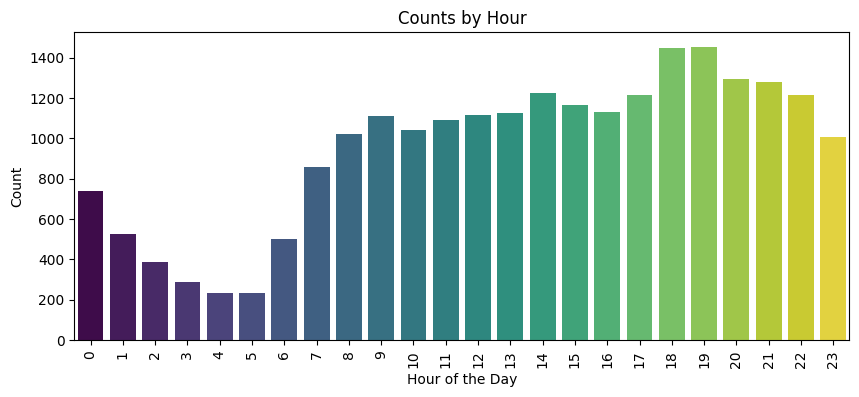

In [60]:
# Plotting a bar chart
plt.figure(figsize=(10, 4))
sns.barplot(x=by_hour_rides.index, y=by_hour_rides.values, palette='viridis', hue = by_hour_rides.index, legend = False)
plt.title('Counts by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

In [39]:
def is_rush_hour(hour, day):
    return ((6 <= hour < 10) or (16 <= hour < 20)) and ((day != "saturday") and (day != "sunday"))
df["rush_hour"] = df.apply(lambda x: 1 if is_rush_hour(x["hour"], x["day"]) else 0, axis = 1)

# Remove the hour column and print the first rows to ensure the new columns were added
df.drop("hour", axis = 1, inplace = True)
df.head(5)

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration,day,month,rush_hour
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,...,0.0,0.5,2.76,0.0,0.3,16.56,14.066667,saturday,march,0
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,...,0.0,0.5,4.00,0.0,0.3,20.80,26.500000,tuesday,april,0
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,...,0.0,0.5,1.45,0.0,0.3,8.75,7.200000,friday,december,1
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,...,0.0,0.5,6.39,0.0,0.3,27.69,30.250000,sunday,may,0
4,30841670,2,2017-04-15 23:32:20,2017-04-15 23:49:03,1,4.37,1,N,4,112,...,0.5,0.5,0.00,0.0,0.3,17.80,16.716667,saturday,april,0


Let's quickly verify saturday and sunday are never encoded as rush_hour

In [40]:
df.groupby("day")["rush_hour"].max()

day
friday       1
monday       1
saturday     0
sunday       0
thursday     1
tuesday      1
wednesday    1
Name: rush_hour, dtype: int64

Let's see do some quick analysis of these new variables and see if the final total of rides varies by the value of our new columns

In [41]:
daily_revenue = df.groupby("day")["total_amount"].sum()
monthly_revenue = df.groupby("month")["total_amount"].sum()
# Seperate out the weekends so that a comparison can be made on rush_hour using only weekdays
df_no_weekends = df[(df["day"] != "saturday") & (df["day"] != "sunday")]
rush_hour_revenue = df_no_weekends.groupby("rush_hour")["total_amount"].sum()

C:\Users\admin\AppData\Local\Temp\ipykernel_29088\3942126963.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)  # Rotate x-axis labels
C:\Users\admin\AppData\Local\Temp\ipykernel_29088\3942126963.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)  # Rotate x-axis labels


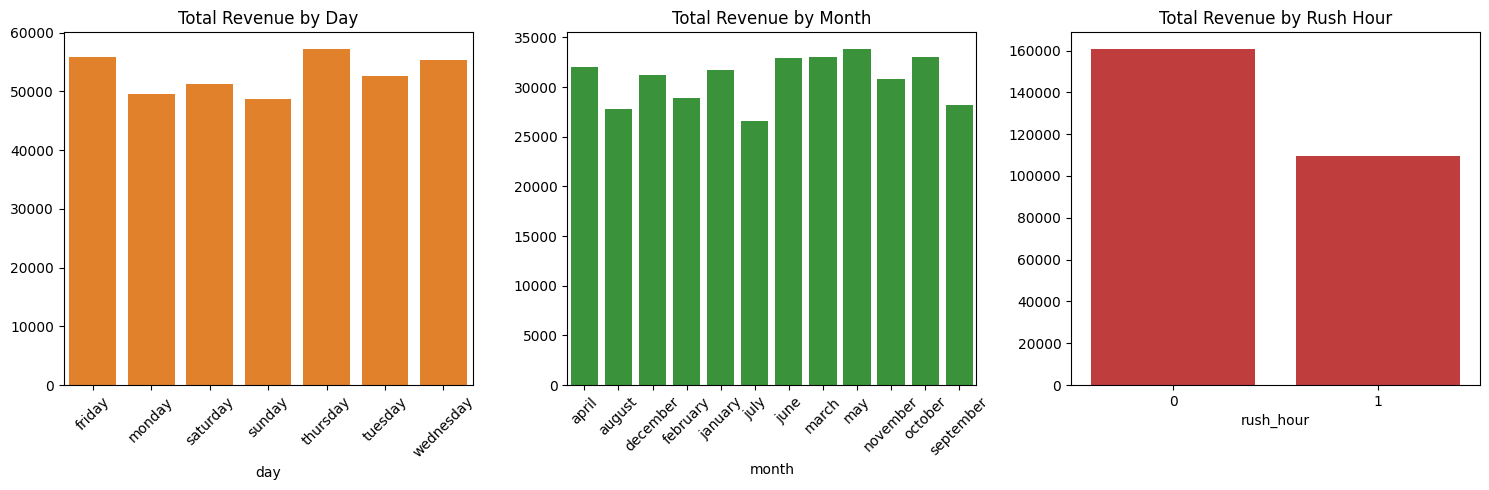

In [42]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Group by "day", "month", and "rush_hour", calculate mean of "total_amount", and plot as bar chart
sns.barplot(x=daily_revenue.index, y=daily_revenue.values, ax=axes[0], color = "tab:orange")
axes[0].set_title("Total Revenue by Day")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)  # Rotate x-axis labels

sns.barplot(x=monthly_revenue.index, y=monthly_revenue.values, ax=axes[1], color = "tab:green")
axes[1].set_title("Total Revenue by Month")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)  # Rotate x-axis labels

sns.barplot(x=rush_hour_revenue.index, y=rush_hour_revenue.values, ax=axes[2], color = "tab:red")
axes[2].set_title("Total Revenue by Rush Hour")

# Adjust layout
plt.tight_layout()
plt.show()

## Fare Amount, Tip Amount & Duration Outliers & Errors


In [43]:
df.describe()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration,rush_hour
count,2.269900e+04,22699.000000,22699,22699,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000
mean,5.675849e+07,1.556236,2017-06-29 07:32:48.973126656,2017-06-29 07:49:49.799726848,1.642319,2.913313,1.043394,162.412353,161.527997,1.336887,13.026629,0.333275,0.497445,1.835781,0.312542,0.299551,16.310502,17.013777,0.296753
min,1.212700e+04,1.000000,2017-01-01 00:08:25,2017-01-01 00:17:20,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,-120.000000,-1.000000,-0.500000,0.000000,0.000000,-0.300000,-120.300000,-16.983333,0.000000
25%,2.852056e+07,1.000000,2017-03-30 03:09:38.500000,2017-03-30 03:11:20.500000,1.000000,0.990000,1.000000,114.000000,112.000000,1.000000,6.500000,0.000000,0.500000,0.000000,0.000000,0.300000,8.750000,6.650000,0.000000
50%,5.673150e+07,2.000000,2017-06-23 12:35:57,2017-06-23 12:55:11,1.000000,1.610000,1.000000,162.000000,162.000000,1.000000,9.500000,0.000000,0.500000,1.350000,0.000000,0.300000,11.800000,11.183333,0.000000
75%,8.537452e+07,2.000000,2017-10-02 10:34:34,2017-10-02 10:53:47,2.000000,3.060000,1.000000,233.000000,233.000000,2.000000,14.500000,0.500000,0.500000,2.450000,0.000000,0.300000,17.800000,18.383333,1.000000
max,1.134863e+08,2.000000,2017-12-31 23:45:30,2017-12-31 23:49:24,6.000000,33.960000,99.000000,265.000000,265.000000,4.000000,999.990000,4.500000,0.500000,200.000000,19.100000,0.300000,1200.290000,1439.550000,1.000000
std,3.274493e+07,0.496838,NaN,NaN,1.285231,3.653171,0.708391,66.633373,70.139691,0.496211,13.243791,0.463097,0.039465,2.800626,1.399212,0.015673,16.097295,61.996482,0.456837


The minimum values for fare_amount and duration are negative and neither of them should logically be a negative value, so we have spotted an error.
This is likely due to an error where the fare was actually 120, but was input with a negative value by mistake. Either way we will have to clean up this error. Since a negative fare_amount does not make any logical sense, let's impute all negative fare_amounts with a value of 0.

In [44]:
df.loc[df['fare_amount'] < 0, 'fare_amount'] = 0
print(df['fare_amount'].min())

df.loc[df['duration'] < 0, 'duration'] = 0
print(df['duration'].min())

0.0
0.0


We notice there is also a severe outlier within fare_amount that is $999.99, we also notice that the max tip_amount is $200.00 and max total_amount is $1200.00, so a likely story to assume here is that there was a single instance with between a rider and driver where the rider was extremely generous towards the driver. Whatever the story is, these values are not indicative of the data set as a whole, and will only serve to skew later predictions upwards. So let's remove these outliers. We will define an outlier to be a realistic factor of the IQR, and remove rows with values that exceed the upper bound we set. So first let's create two boxplots to visualize the IQR of both fare_amount and tip_amount.

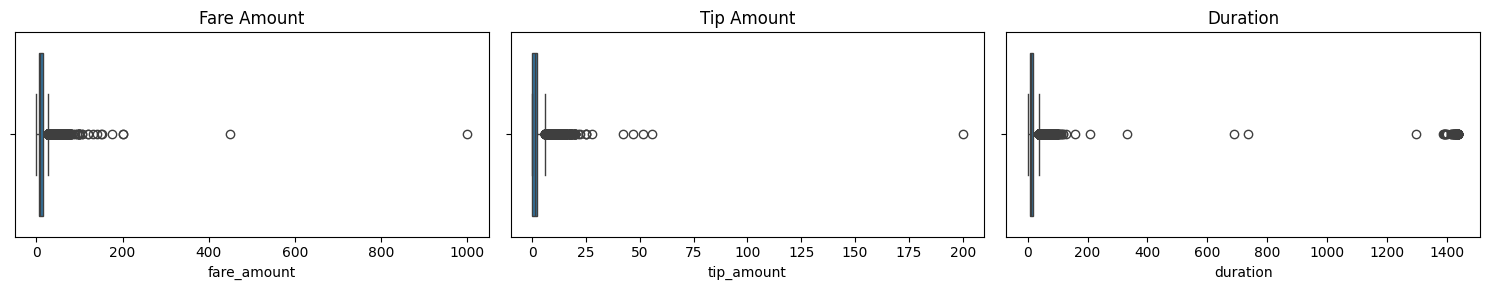

Upper bound for Fare Amount: 26.5 (IQR): 8.0
Upper bound for Tip Amount: 6.125 (IQR): 2.45
Upper bound for Duration: 22.06 (IQR): 11.73


In [45]:

plt.figure(figsize=(15, 3))

plt.subplot(1, 3, 1)
sns.boxplot(data=df["fare_amount"], orient="h")
plt.title('Fare Amount')

plt.subplot(1, 3, 2)
sns.boxplot(data=df["tip_amount"] , orient="h")
plt.title('Tip Amount')

plt.subplot(1, 3, 3)
sns.boxplot(data=df["duration"] , orient="h")
plt.title('Duration')

plt.tight_layout()
plt.show()

iqr_fare = np.quantile(df["fare_amount"], 0.75) - np.quantile(df["fare_amount"], 0.25)
iqr_tip = np.quantile(df["tip_amount"], 0.75) - np.quantile(df["tip_amount"], 0.25)
iqr_time = np.quantile(df["duration"], 0.75) - np.quantile(df["duration"], 0.25)
print(f'Upper bound for Fare Amount: {np.quantile(df["fare_amount"], 0.75) + 1.5*iqr_fare} (IQR): {iqr_fare}')
print(f'Upper bound for Tip Amount: {np.quantile(df["tip_amount"], 0.75) + 1.5*iqr_tip} (IQR): {iqr_tip}')
print(f'Upper bound for Duration: {round((np.quantile(df["duration"], 0.75) + 1.5*iqr_tip),2)} (IQR): {round(iqr_time,2)}')

The oulier upperbound for fare_amouont, tip_amount and duration are 26.5, 6.125 and 22.06 respectively, Both of with are intuitvely low, since even for some range above this bound, the values are likely from longer rides and therefore warranted and logical data that should not be removed. So let's set our outlier bound to Q3 + 5*IQR for bounds of 54.5 for fare_amount and 14.7 for tip_amount and 63.115 for duration.

In [46]:
def remove_outliers(df, columns, threshold=1.5):
    df_clean = df.copy()  # Create a copy of the DataFrame to avoid modifying the original
    
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        df_clean = df_clean[(df_clean[column] >= lower_bound) & (df_clean[column] <= upper_bound)]
    
    return df_clean

rows_before = df.shape[0]
df = remove_outliers(df=df, columns=["fare_amount","tip_amount","duration"], threshold = 5)
rows_after = df.shape[0]

print(f'Rows before: {rows_before}\nRows after: {rows_after}\nNumber of rows removed: {rows_before-rows_after}')

Rows before: 22699
Rows after: 22453
Number of rows removed: 246


In [47]:
df.describe()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration,rush_hour
count,2.245300e+04,22453.000000,22453,22453,22453.000000,22453.000000,22453.000000,22453.000000,22453.000000,22453.000000,22453.000000,22453.000000,22453.000000,22453.000000,22453.000000,22453.000000,22453.000000,22453.000000,22453.000000
mean,5.672249e+07,1.554982,2017-06-29 04:55:30.164744192,2017-06-29 05:09:30.031933184,1.640404,2.795639,1.026544,162.456821,161.700708,1.336659,12.495235,0.331359,0.498753,1.757598,0.269789,0.299586,15.655547,13.998543,0.296798
min,1.212700e+04,1.000000,2017-01-01 00:08:25,2017-01-01 00:17:20,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,-1.000000,-0.500000,0.000000,0.000000,-0.300000,-5.800000,0.000000,0.000000
25%,2.845998e+07,1.000000,2017-03-29 23:26:45,2017-03-29 23:37:55,1.000000,0.990000,1.000000,114.000000,112.000000,1.000000,6.500000,0.000000,0.500000,0.000000,0.000000,0.300000,8.500000,6.633333,0.000000
50%,5.673294e+07,2.000000,2017-06-23 13:06:15,2017-06-23 13:13:47,1.000000,1.600000,1.000000,162.000000,162.000000,1.000000,9.500000,0.000000,0.500000,1.350000,0.000000,0.300000,11.800000,11.100000,0.000000
75%,8.531924e+07,2.000000,2017-10-02 09:48:22,2017-10-02 09:51:44,2.000000,3.000000,1.000000,233.000000,233.000000,2.000000,14.500000,0.500000,0.500000,2.360000,0.000000,0.300000,17.750000,18.083333,1.000000
max,1.134863e+08,2.000000,2017-12-31 23:45:30,2017-12-31 23:49:24,6.000000,30.330000,5.000000,265.000000,265.000000,4.000000,54.500000,4.500000,0.500000,14.640000,16.620000,0.300000,80.900000,76.950000,1.000000
std,3.274037e+07,0.496979,NaN,NaN,1.283983,3.373420,0.205503,66.682455,69.857789,0.495849,9.684025,0.449835,0.030191,2.192145,1.221806,0.015110,11.988128,10.720405,0.456857


## Payment Type

In [48]:
df.sort_values(by="total_amount", ascending=False).tail(15)

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration,day,month,rush_hour
5722,49670364,2,2017-06-12 12:08:55,2017-06-12 12:08:57,1,0.00,1,N,264,193,...,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,monday,june,0
4402,108016954,2,2017-12-20 16:06:53,2017-12-20 16:47:50,1,7.06,1,N,263,169,...,0.0,0.0,0.0,0.0,0.0,0.0,40.950000,wednesday,december,1
1646,57337183,2,2017-07-05 11:02:23,2017-07-05 11:03:00,1,0.04,1,N,79,79,...,0.0,-0.5,0.0,0.0,-0.3,-3.3,0.616667,wednesday,july,0
5758,833948,2,2017-01-03 20:15:23,2017-01-03 20:15:39,1,0.02,1,N,170,170,...,-0.5,-0.5,0.0,0.0,-0.3,-3.8,0.266667,tuesday,january,0
314,105454287,2,2017-12-13 02:02:39,2017-12-13 02:03:08,6,0.12,1,N,161,161,...,-0.5,-0.5,0.0,0.0,-0.3,-3.8,0.483333,wednesday,december,0
18565,43859760,2,2017-05-22 15:51:20,2017-05-22 15:52:22,1,0.10,1,N,230,163,...,0.0,-0.5,0.0,0.0,-0.3,-3.8,1.033333,monday,may,0
10281,55302347,2,2017-06-05 17:34:25,2017-06-05 17:36:29,2,0.00,1,N,238,238,...,-1.0,-0.5,0.0,0.0,-0.3,-4.3,2.066667,monday,june,1
4423,97329905,2,2017-11-16 20:13:30,2017-11-16 20:14:50,2,0.06,1,N,237,237,...,-0.5,-0.5,0.0,0.0,-0.3,-4.3,1.333333,thursday,november,0
5448,28459983,2,2017-04-06 12:50:26,2017-04-06 12:52:39,1,0.25,1,N,90,68,...,0.0,-0.5,0.0,0.0,-0.3,-4.3,2.216667,thursday,april,0
8204,91187947,2,2017-10-28 20:39:36,2017-10-28 20:41:59,1,0.41,1,N,236,237,...,-0.5,-0.5,0.0,0.0,-0.3,-4.8,2.383333,saturday,october,0


We notice that all of the negative total amounts coincide with payments with methods 3 and 4, which when referencing the data manual are "No charge" and "Dispute" respectviely, so the negative values may not be an error after all, but more investigation is warranted. Let's see how common each payment type is.

In [49]:
print(f'payment_type Frequencies {df["payment_type"].value_counts()}')
print("\nAverage tip_amount by payment type")
print(df.groupby("payment_type")["tip_amount"].mean())

payment_type Frequencies payment_type
1    15102
2     7188
3      118
4       45
Name: count, dtype: int64

Average tip_amount by payment type
payment_type
1    2.613121
2    0.000000
3    0.000000
4    0.000000
Name: tip_amount, dtype: float64


It seems "Credit Card" is by far the most popular, followed by "Cash", and then followed by "No Charge" and "Dispute" with reltatively little frequency. It's noted that there are two more types 5 and 6, "Uknown" and "Voided Trip" respectively, that never occur in this dataset. When looking at the average tip amounts by the payment method, we see that only those that pay with credit cards tip, and all other methods have an average of 0. Let's see how many tips there are in the data set to get a sense if there may be an error or if tipping taxi drivers is just uncommon in NYC.

In [50]:
number_tips = df["tip_amount"][(df["tip_amount"].notna()) & (df["tip_amount"] > 0)].count()
total_rows = len(df)

print(f'(Total Rows = {total_rows}) - (Rows with Tips = {number_tips}) = {total_rows-number_tips}')

(Total Rows = 22453) - (Rows with Tips = 14494) = 7959


With nearly 15000 tips in the data set, supposedly all of them are from people paying by credit card, that makes a 14642/15265 = 96% tip rate by those with credit cards and a 0% rate for all other methods. Some investigation will need to be done reguarding if this is just a quirk with how credit cards are used, perhaps a tip is automatically applied in most cases with an option to select no tip, this would explain the high tip rate among credit card users. Perhaps also cash tips are not recorded by the drivers and instead just pocketed directly for any number of reasons, but this is only speculation. (Upon closer inspection of the data manual, both of the above reasons were true)

Let's now see if we can gain any insight into the cost of the trip based on the payent_type used by the rider. Since we already know that the final_amount metric is biased due to the omission of cash tips, lets instead look at the fare amount for any information.

In [51]:
df.groupby("payment_type")["fare_amount"].mean()[:2]

payment_type
1    12.855516
2    11.747565
Name: fare_amount, dtype: float64

It seems that those that pay with credit card end up paying roughly $1.20 more on their fares. let's conduct a hypothesis test to see if this is an statitsically relevant insight.

For our h-test we will use a two sample t-test and a significance level of 5% or 0.05. And our hypotheses will be:

H_o will be that there is no difference in the average fare amount by payment type.

H_a will be that there is a difference in the average fare amount by payment type.

In [52]:
card = df[df["payment_type"] == 1]
cash = df[df["payment_type"] == 2]

stats.ttest_ind(a = card["fare_amount"], b = cash["fare_amount"], equal_var=False)

TtestResult(statistic=8.176034477651516, pvalue=3.169157590321286e-16, df=14835.427831110026)

The resulting p-value is very small; meaning that we can reject the null hypothesis and must accept that there is a significant difference in the average fare_amount charged to those paying by credit cards versus those paying by cash, suggesting that it would be wise to encode a binary variable in the final model to capture this information.

## Vendor Type & Passenger Count

Now lets look at the vendor types, according to the data manual there are two vendor types and they correspond to the provider of the record or trip data. Let's look to see which provider has more or less expensive services

In [53]:
print(f'Total trips by vendor:\n {df["VendorID"].value_counts()}')
print(f'\nAverage total_amount by vendor:\n{df.groupby("VendorID")["total_amount"].mean()}')

Total trips by vendor:
 VendorID
2    12461
1     9992
Name: count, dtype: int64

Average total_amount by vendor:
VendorID
1    15.685711
2    15.631360
Name: total_amount, dtype: float64


We can see that the average total_amount by vendors are nearly identical, let's see now if there is any change in total amount for different numbers of passengers.

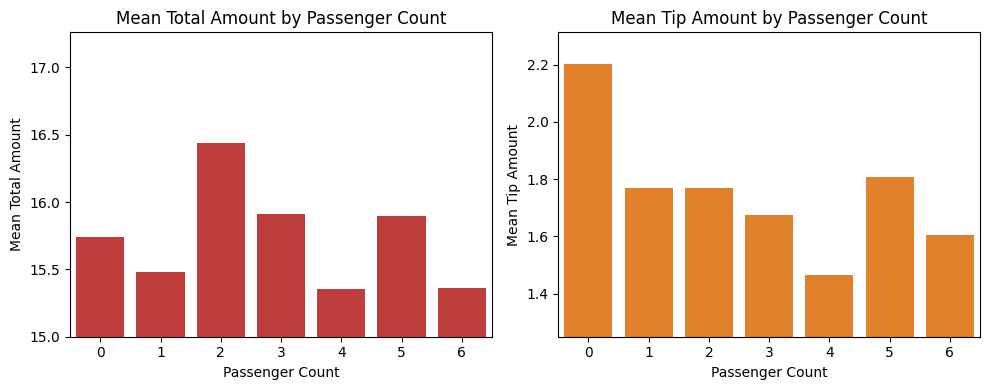

In [54]:
avg_total_amount = df.groupby("passenger_count")["total_amount"].mean()
avg_tip_amount = df.groupby("passenger_count")["tip_amount"].mean()

plt.figure(figsize=(10, 4))

# Plot Mean Total Amount by Passenger Count
plt.subplot(1,2,1)
sns.barplot(x=avg_total_amount.index, y=avg_total_amount.values, color="tab:red")
plt.ylim(15)
plt.xlabel('Passenger Count')
plt.ylabel('Mean Total Amount')
plt.title('Mean Total Amount by Passenger Count')

# Plot Mean Tip Amount by Passenger Count
plt.subplot(1,2,2)
sns.barplot(x=avg_tip_amount.index, y=avg_tip_amount.values, color="tab:orange")
plt.ylim(1.25)
plt.xlabel('Passenger Count')
plt.ylabel('Mean Tip Amount')
plt.title('Mean Tip Amount by Passenger Count')

plt.tight_layout()  # Adjust subplots to fit nicely in the figure
plt.show()

We see no real discernable difference in the total amounts by different numbers of passengers (Note the Y-axes are regularized for a better display, and the differences in the data are much less percievable than they appear in the graphs above), if anything, total_amount peaks and decreases after 2 passengers and oddly enough trips with no passengers are the most expensive on average. This could once again be an error in the dataset that needs investigation, however it's also noted that this only occurs 33 times, and could likely be an event such as a driver being paid to deliver a package for someone, and not actually transporting a rider. Inquiry with the drivers would be necessary for these 33 points, otherwise complete omission from the dataset could perhaps be wise. 

## Trip Distance

Now let's see the effect trip_distance has on total_amount, but first we'll have to seperate the tens of thousands of rows into a more usable format, so we'll split it into 11 new groups based off trip_distance, then find the mean of total amount for each group and plot another bar chart.

In [55]:
bins = [0.0]
for i in range(1,11):
    bins.append(i/10)

quantiles = []
for i in bins:
    quantiles.append(df['trip_distance'].quantile(i))        
quantiles.sort()
print(quantiles)

df['group'] = pd.cut(df['trip_distance'], bins=quantiles, include_lowest=True, right=True, duplicates='drop')
avg_ta_trip_dist = df.groupby('group', observed=False)['total_amount'].mean()
print(avg_ta_trip_dist)

[0.0, 0.61, 0.87, 1.1, 1.31, 1.6, 2.0, 2.6, 3.6, 6.42, 30.33]
group
(-0.001, 0.61]     7.197508
(0.61, 0.87]       7.812652
(0.87, 1.1]        9.113743
(1.1, 1.31]       10.183998
(1.31, 1.6]       11.300934
(1.6, 2.0]        12.647548
(2.0, 2.6]        14.503570
(2.6, 3.6]        17.315095
(3.6, 6.42]       22.703747
(6.42, 30.33]     44.326695
Name: total_amount, dtype: float64


C:\Users\admin\AppData\Local\Temp\ipykernel_29088\2833365398.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(avg_ta_trip_dist_keys, rotation=45, ha="right")


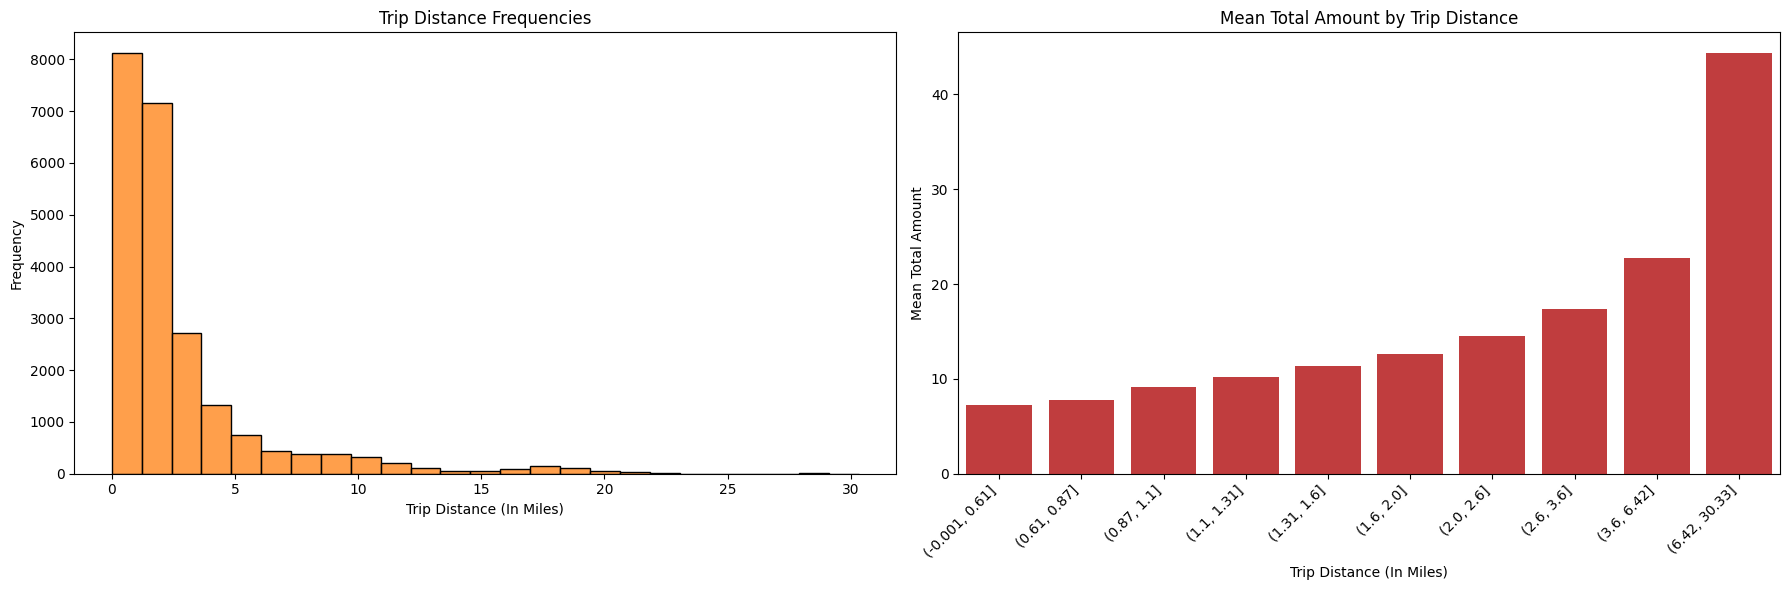

Number of rides with distance of 0 miles: 130


In [56]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Plot histogram using Seaborn on the first subplot
sns.histplot(df["trip_distance"], bins=25, color="tab:orange", ax=axes[0])
axes[0].set_xlabel('Trip Distance (In Miles)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Trip Distance Frequencies')

# Plot bar chart using Seaborn on the second subplot
avg_ta_trip_dist_keys = avg_ta_trip_dist.index.tolist()
avg_ta_trip_dist_values = avg_ta_trip_dist.values.tolist()
sns.barplot(x=avg_ta_trip_dist_keys, y=avg_ta_trip_dist_values, color="tab:red", ax=axes[1])
axes[1].set_xticklabels(avg_ta_trip_dist_keys, rotation=45, ha="right")
axes[1].set_xlabel('Trip Distance (In Miles)')
axes[1].set_ylabel('Mean Total Amount')
axes[1].set_title('Mean Total Amount by Trip Distance')

# Adjust layout and display the figure
plt.tight_layout()
plt.show()

print(f'Number of rides with distance of 0 miles: ' + str(sum(df['trip_distance']==0)))

As expected we see a gradual increase in trip distance to the total cost (it looks exponential only because there are trips with oulier distances as shown in the left hand graph) this relationship will be important to know later when we intend to predict the cost of a trip before it is taken, likely we will use machine learning to get as close to exact predictions on this relationship. It is also noted that there is a number of rides (148) that have a distance of 0, this could be due to any number of errors in the data entry however since the number of errors in this case (148 / 22000+) is relatively small. We will elect to not worry about thier effect on the final model that gets created.

# ADD SECTION PROVING ASSUMPTIONS FOR LIN_REG

# ANALYSIS ON PICKUP/DROPOFF

# ANALYSIS ON DAY AND MONTH AND RUSH_HOUR COLUMNS

# DROP IRRELEVANT COLUMNS AND RE-INDEX

# BUILD A FEW DIFFERENT MODELS

In [57]:
df.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration,day,month,rush_hour,group
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,...,0.5,2.76,0.0,0.3,16.56,14.066667,saturday,march,0,"(2.6, 3.6]"
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,...,0.5,4.00,0.0,0.3,20.80,26.500000,tuesday,april,0,"(1.6, 2.0]"
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,...,0.5,1.45,0.0,0.3,8.75,7.200000,friday,december,1,"(0.87, 1.1]"
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,...,0.5,6.39,0.0,0.3,27.69,30.250000,sunday,may,0,"(3.6, 6.42]"
4,30841670,2,2017-04-15 23:32:20,2017-04-15 23:49:03,1,4.37,1,N,4,112,...,0.5,0.00,0.0,0.3,17.80,16.716667,saturday,april,0,"(3.6, 6.42]"


In [58]:
df["PULocationID"].nunique()
df["DOLocationID"].nunique()

212